In this assignment, we will learn how to build simple neural networks. We will build the three basic blocks we learnt in class: the perceptron, the LinearRegression classifier (Fisher discriminant) and the Support Vector Machine. All these three are just one-neuron "networks". In each case, we train the neuron (ie set the weights) by minimizing a different kind of loss function. Specifically:
1. Perceptron: activation is linear, train by minimizing the ramp loss = max(0, -y_true* y_predicted)
2. Fisher Discriminant: activation is linear, train by minimizing square loss (y_true - y_predicted)^2
3. Support vector machine: activation is linear (for now). We train by minimizing the hinge loss = max(0, 1- y_true* y_predicted), but to the hinge loss, we add a (1/C)||w||^2 term, where C is some constant. In machine learning parlance, adding a ||w||^2 term to the loss is called l2 regularization. So this is a single neuron, linear activation, trained using hinge loss with l2 regularization.

This assignment will build all three neurons. Rather than code each one from scratch, we are going to use off-the-shelf components from keras, and use gradient descent to learn the weights. To help you, I have simulated the one neuron network that simulates the perceptron completely (and as you can see, it does separate linearly separable data by running enough epochs). 

In the code below, every component of keras is stripped down to its bare essentials, so we know what is happening. We will learn to add back the more complicated parts later. 

In [1]:
import numpy as np


import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

import tensorflow as tf

A good linearly separable dataset is the IRIS dataset (contains dimensions of various flowers, the task is to classify the type of flower). It has a nice backstory as well.

In [2]:
from sklearn import datasets

iris = datasets.load_iris()


# let us check what has been loaded
print(dir(iris))
# a short description
print(iris.DESCR)
print(iris.target_names)

['DESCR', 'data', 'feature_names', 'filename', 'frame', 'target', 'target_names']
.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.2

In [8]:
B = iris.data[:,[1,2]]

print(B[:5,])
y = np.where(iris.target == 0, 1, -1)
print(y)

[[3.5 1.4]
 [3.  1.4]
 [3.2 1.3]
 [3.1 1.5]
 [3.6 1.4]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1]


Let us visualize the dataset, after all there are only 4 features. Let us plot all examples in the space of the first three features. Based on the class (0,1,2---corresponding to setosa, versicolor and virginica respectively), we assign a different color. The darkest dots are the setosa examples, the green ones are versicolor and the yellow ones are virginica (compare with the colorbar at 0, 1 and 2, I am a little colorblind myself).

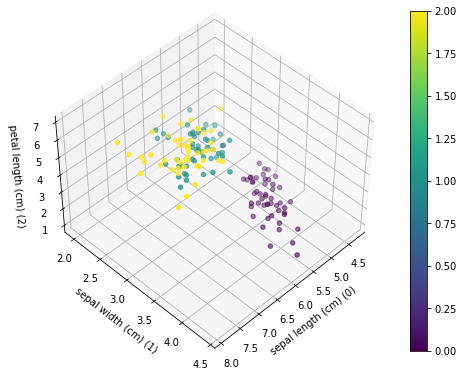

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
figiris = ax.scatter(iris.data[:,0],iris.data[:,1],iris.data[:,2],c=iris.target)
ax.set_xlabel(iris.feature_names[0]+' (0)')
ax.set_ylabel(iris.feature_names[1]+' (1)')
ax.set_zlabel(iris.feature_names[2]+' (2)')

# this adjusts the space around the plot so we can read the z label
plt.gcf().subplots_adjust(left=-0.5,bottom=-0.3)


plt.colorbar(figiris)
ax.view_init(45,45)

Choosing sepal width (feature 1) against petal length (feature 2) seems to yield linearly separable points if we want to classify the setosia (label 0) examples against all the other examples. Let us double check that.


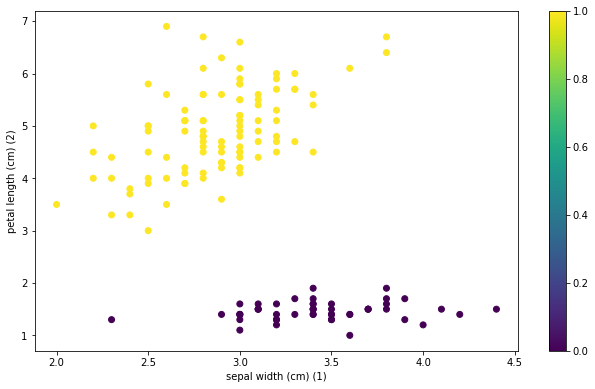

In [5]:
fig = plt.figure()
ax2 = plt.axes()
figiris = ax2.scatter(iris.data[:,1],iris.data[:,2],c=np.where(iris.target == 0, 0,1))
ax2.set_xlabel(iris.feature_names[1]+' (1)')
ax2.set_ylabel(iris.feature_names[2]+' (2)')

# this adjusts the space around the plot so we can read the z label
plt.gcf().subplots_adjust(left=-0.5,bottom=-0.3)

plt.colorbar(figiris)
ax.view_init(45,45)

Sure enough it works. Let us train a perceptron with this data. Our training data are features 1 and 2, label is 1 if setosia, -1 else. A perceptron is a neural network with 1 layer, 1 node, linear activation function, and the ramp loss we discussed in class. Its inputs are weight two vectors (features 1 and 2). 

We could implement the perceptron algorithm as a loop of course. But we have a better way: to do this in keras. keras allows us to build a wide variety of networks either by simply building them layer by layer (Sequential) or as arbitrary graphs (we will worry about this later).

With the perceptron, 
1. The topology is trivial---just a single layer with one neuron
2. The input here has dimension 2 (feature 1 and 2)

Let us first put that into keras. keras also wants to know what activation function to use. To understand the activation function, recall that the neuron computes the dot product between the example and its weights. The activation function is applied to the dot product. 

When we learnt about this topic, we initially used the sign activation function (label was the sign of the dot product). But doing so yielded a loss terrain with plateaus at different heights (run the old demo again if you do not remember). It is difficult to figure out which direction to move while doing gradient descent, so we shifted to the ramp loss instead. To compute the ramp loss, we just ask the neuron to output the entire dot product---so essentially, we want the activation function to leave the dot product unchanged. The way to do that is to use the linear activation function (f(x)=x).

One additional detail here. In class, we ignored the intercept. Here we will use the intercept---so we will classify using a plane w^T x +b =0 (instead of just planes through the origin, w^T x=0). The keras neuron automatically makes the intercept available. 

Conceptually, the intercept is not a big deal---we just pretend that the weights in the neuron are the coefficients of the input coordinates and the intercept b. So here, since the input has dimension 2, we have two coefficients and one intercept---bringing the number of tunable weights to be 3. We also pretend that every example is actually a vector with 3 coordinates, the first two coordinates are the ones given to us and the last coordinate is simply 1. Then w^T z +b = (w,b)^T(z,1), so we have reduced it to a case without an intercept (albeit by adding in an additional dummy coordinate).


In [6]:
# This piece of code defines the perceptron as above. 

perceptron = Sequential([
    Dense(1, input_shape=(2,)),
    Activation('linear'),
])

Ok, now on to the training algorithm. Recall that we use
1. stochastic gradient descent on the 
2. the ramp loss function

keras has a lot of useful loss functions built in, but the ramp loss is not one of them (though the hinge loss is). We will just write the function out here. Unfortunately, here there is a catch---we cannot use the extensive numpy libraries (though it is ok to pass numpy arrays here). Instead we have to use the tensorflow functions, which can sometimes be a little clumsy and eschews lot of automatic type conversions (because it is built for speed, not convenience always). That is why we explicity convert the label to a float below (else we could not multiply in the last line), and note that we write max (0.0, ...) not max (0, ...). This is to indicate that the comparison is a float comparison. If you do not do these things, TensorFlow will complain. 

loss functions we define *must* be tensorflow functions, and *always* take in two arguments (y_true and y_pred). y_true is the correct label of the example while y_pred is the output of the neuron (in our case, z\dot w, since we used linear activation). 

Finally perceptron training algorithm was vanilla stochastic gradient descent with learning parameter 1. We first pass the name of the algorithm (sgd for stochastic gradient descent, which is built into keras), the loss and what we are interested in achieving on test data (accuracy of classification---categorical accuracy in other words). 

In [33]:
from keras.optimizers import SGD

# the ramp loss we used is not predefined, so we define it ourselves here. The code here is tensorflow
# code as is required. We cannot use numpy code/data types here.

def perceptron_loss(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return(tf.maximum(0.0,-(y_true)*y_pred))


print(perceptron_loss([1,1,-1], [.5,-.1,-.5]))
# We want to do plain vanilla stochastic gradient descent here, nothing fancy. 
# The call below removes all bells and whistles from the keras implementation of stochastic gradient
# descent. We will learn how to add back the momentum and Nesterov acceleration later.

opt = SGD(lr=1,momentum=0,nesterov=False)
#opt = SGD(lr=.01, momentum=0, nesterov=False)

# Here we tell the perceptron to use plain vanilla stochastic gradient descent to optimize the perceptron loss defined
# above (look at keras: change perceptron_loss to mse)

perceptron.compile(optimizer=opt, loss=perceptron_loss)
#perceptron.compile(optimizer=opt, loss=tf.keras.losses.MeanSquaredError())

tf.Tensor([0.  0.1 0. ], shape=(3,), dtype=float32)


We set the learning rate to 1 so as to mimic the Perceptron Training Algorithm exactly. 

Now, we prepare the training data by extracting columns 1 and 2 from the data. We want to separate out setosa (original label 0) from the other two classes, so we assign label 1 to setosas (original label 0) and -1 to the other two classes (original labels 1 and 2). 

In [29]:
# Get hold of the training data. We will classify setosas vs the other two. This yields a linear separable data
# that we know the perceptron can handle.

training = iris.data[:,[1,2]]
labels = np.where(iris.target == 0, 1,-1)

n = training.shape[0]

# We shuffle the order of the training examples and labels. Normally
# keras does this automatically. Here, we do it manually and we will
# ask keras not to shuffle. This is so that we can observe the perceptron
# algorithm as it progresses.

from sklearn.utils import shuffle

training, labels = shuffle(training, labels)


Now we just get keras to train our model, and get the output at the end of the training into w

In [34]:
from keras.callbacks import LambdaCallback
import keras.backend as K
    
# We initialize weights to something a little away from 0, since the perceptron has 0 loss when the weights are exactly 0
# regardless of input and output. This is because when weights are 0, w^Tz -b = 0^Tz -0 =0, so our prediction is 0. Therefore,
# y_true*y_predicted =0 always. This is not a fatal flaw, it just means we cannot start at 0.

perceptron.layers[0].set_weights([np.array([[0.01],[0.01]]),np.array([0.0])])

# The line below trains the perceptron.
# In the line below, increase the number of epochs till you see the loss become 0. You may need more than one/two epochs.

perceptron.fit(training, labels, epochs=2, batch_size=1, shuffle=False)

# These are weights obtained after training.

w = perceptron.layers[0].get_weights()

Epoch 1/2
150/150 [==============================] - 0s 399us/step - loss: 0.2155
Epoch 2/2
150/150 [==============================] - 0s 391us/step - loss: 0.0000e+00


Let us plot the separating line. The line is w0 x + w1 y + b=0, or y = -(b+w0 x)/w1

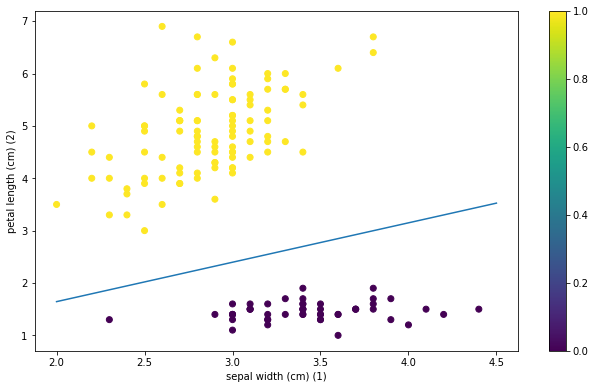

In [35]:
fig = plt.figure()
ax2 = plt.axes()
figiris = ax2.scatter(iris.data[:,1],iris.data[:,2],c=np.where(iris.target == 0, 0,1))
ax2.set_xlabel(iris.feature_names[1]+' (1)')
ax2.set_ylabel(iris.feature_names[2]+' (2)')
x = np.linspace(2,4.5,100)
plt.plot(x, -(w[1][0]+w[0][0,0]*x)/w[0][1,0])
# this adjusts the space around the plot so we can read the z label
plt.gcf().subplots_adjust(left=-0.5,bottom=-0.3)

plt.colorbar(figiris)
ax.view_init(45,45)

It worked as we expected it to! We want a little more transparency of course. Let us also retrieve the input and weights at the beginning of every example.

In [36]:
from keras.callbacks import LambdaCallback
import keras.backend as K
    
print_weights = LambdaCallback(on_batch_begin=lambda batch, logs: print('\n w',batch,': \n',perceptron.layers[0].get_weights(),'\n'))
print_examples = LambdaCallback(on_batch_end = lambda batch, logs: print('\n z: ',training[batch,:],'y: ', labels[batch]))

# Again we initialize weights
perceptron.layers[0].set_weights([np.array([[0.01],[0.01]]),np.array([0.0])])
# And start stochastic gradient descent. This time, we print out the weights and examples corresponding to each step of the
# SGD.
perceptron.fit(training, labels, epochs=1, batch_size=1, callbacks = [ print_weights, print_examples ],shuffle=False)


 w 0 : 
 [array([[0.01],
       [0.01]], dtype=float32), array([0.], dtype=float32)] 


 z:  [2.9 1.4] y:  1
  1/150 [..............................] - ETA: 0s - loss: 0.0000e+00
 w 1 : 
 [array([[0.01],
       [0.01]], dtype=float32), array([0.], dtype=float32)] 


 z:  [2.9 6.3] y:  -1

 w 2 : 
 [array([[-2.89],
       [-6.29]], dtype=float32), array([-1.], dtype=float32)] 


 z:  [3.2 5.9] y:  -1

 w 3 : 
 [array([[-2.89],
       [-6.29]], dtype=float32), array([-1.], dtype=float32)] 


 z:  [4.2 1.4] y:  1

 w 4 : 
 [array([[ 1.3099997],
       [-4.89     ]], dtype=float32), array([0.], dtype=float32)] 


 z:  [4.1 1.5] y:  1

 w 5 : 
 [array([[ 5.41     ],
       [-3.3899999]], dtype=float32), array([1.], dtype=float32)] 


 z:  [3.2 1.6] y:  1

 w 6 : 
 [array([[ 5.41     ],
       [-3.3899999]], dtype=float32), array([1.], dtype=float32)] 


 z:  [2.8 6.7] y:  -1

 w 7 : 
 [array([[ 5.41     ],
       [-3.3899999]], dtype=float32), array([1.], dtype=float32)] 


 z:  [3.4 5.4] 

 75/150 [==============>...............] - ETA: 0s - loss: 0.4309
 w 75 : 
 [array([[ 5.41],
       [-7.19]], dtype=float32), array([1.], dtype=float32)] 


 z:  [3.2 1.3] y:  1

 w 76 : 
 [array([[ 5.41],
       [-7.19]], dtype=float32), array([1.], dtype=float32)] 


 z:  [3.2 4.5] y:  -1

 w 77 : 
 [array([[ 5.41],
       [-7.19]], dtype=float32), array([1.], dtype=float32)] 


 z:  [2.7 4.1] y:  -1

 w 78 : 
 [array([[ 5.41],
       [-7.19]], dtype=float32), array([1.], dtype=float32)] 


 z:  [3.  5.2] y:  -1

 w 79 : 
 [array([[ 5.41],
       [-7.19]], dtype=float32), array([1.], dtype=float32)] 


 z:  [3.9 1.3] y:  1

 w 80 : 
 [array([[ 5.41],
       [-7.19]], dtype=float32), array([1.], dtype=float32)] 


 z:  [3.4 1.4] y:  1

 w 81 : 
 [array([[ 5.41],
       [-7.19]], dtype=float32), array([1.], dtype=float32)] 


 z:  [3.9 1.7] y:  1

 w 82 : 
 [array([[ 5.41],
       [-7.19]], dtype=float32), array([1.], dtype=float32)] 


 z:  [2.5 3.9] y:  -1

 w 83 : 
 [array([[ 5.41],

Note above that whenever there is a mistake made, the weights are updated as:

w_{i+1} = w_i +y_i z_i.

Note again that here there are effectively three weights: the two coefficients of the coordinates of the example and the intercept, because we are looking for separating boundaries that are lines not necessarily through the origin. Correspondingly, each example is interpreted as a vector of length 3, the first two coefficients being the actual example and the third coordinate equal to 1 always. 

This is exactly the perceptron training algorithm we studied in class. We have simulated it exactly using keras and gradient descent.

Your assignment is as follows:

### Problem 1. 
a. Using keras and gradient descent, simulate a 1-neuron network that mimics LinearRegression. Use a learning rate of .01 here.

b. Test your simulation on the Iris dataset above. This time do both cases: (a) classes that are *NOT* linearly separable (for eg. label 1 in the IRIS dataset from the other two) and (b) classes that are linearly separable as above. Make sure if the gradients are what you expect by checking the weights before and after an example using callbacks as above. Later on, we will learn how to extract/manipulate gradient information. Choose the batch size wisely.

### Problem 2.
a. Using keras and gradient descent, simulate a 1-neuron network that mimics support vector machine (namely minimize hinge loss, but add in l2 regularization for the model weights). You will have to look up the documentation on keras.regularizers (if you fail to figure this out, email me with the steps you tried). 

b. As before, test your algorithm on the Iris dataset above to classify non-linearly separable classes. Again, check if the gradients are what you expect by checking the weights before and after an example using callbacks as above. 


In [1]:

svm_neuron = Sequential([
    Dense(1, input_shape=(2,), kernel_regularizer=regularizers.L2(.1)),
    Activation('linear'),
])


#opt = SGD(lr=1,momentum=0,nesterov=False)
opt = SGD(lr=.01, momentum=0, nesterov=False)

# Here we tell the perceptron to use plain vanilla stochastic gradient descent to optimize the perceptron loss defined
# above (look at keras: change perceptron_loss to mse)

svm_neuron.compile(optimizer=opt, loss=tf.keras.losses.Hinge())
#perceptron.compile(optimizer=opt, loss=tf.keras.losses.MeanSquaredError())

NameError: name 'Sequential' is not defined